In [1]:
!pip install torch torchvision faiss-cpu scikit-learn kagglehub tqdm matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 44.7 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

print("Path to dataset files:", path)

100%|██████████| 26.4M/26.4M [00:00<00:00, 149MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kaustubhdikshit/neu-surface-defect-database/versions/1


In [3]:
import os

In [7]:
train_root = os.path.join(path, "NEU-DET", "train", "images")
val_root   = os.path.join(path, "NEU-DET", "validation", "images")

print("Train classes:", os.listdir(train_root))
print("Val classes:", os.listdir(val_root))




Train classes: ['patches', 'crazing', 'pitted_surface', 'inclusion', 'scratches', 'rolled-in_scale']
Val classes: ['patches', 'crazing', 'pitted_surface', 'inclusion', 'scratches', 'rolled-in_scale']


In [8]:
import torch
import numpy as np
import faiss
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from PIL import Image
from tqdm import tqdm


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder(root=train_root, transform=transform)
val_dataset   = datasets.ImageFolder(root=val_root, transform=transform)

class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(val_dataset, batch_size=1, shuffle=False)


Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [11]:
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()   # 512-d embeddings
resnet = resnet.to(device)
resnet.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 95.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
embeddings = []
labels = []

with torch.no_grad():
    for imgs, lbls in tqdm(train_loader):
        imgs = imgs.to(device)
        emb = resnet(imgs)
        embeddings.append(emb.cpu().numpy())
        labels.extend(lbls.numpy())

embeddings = np.vstack(embeddings)
labels = np.array(labels)

print("Embeddings shape:", embeddings.shape)
print("Class distribution:", np.bincount(labels))


100%|██████████| 45/45 [02:16<00:00,  3.04s/it]

Embeddings shape: (1440, 512)
Class distribution: [240 240 240 240 240 240]


In [14]:
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)


In [15]:
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(embeddings)

print("Vectors in FAISS index:", index.ntotal)


Vectors in FAISS index: 1440


In [16]:
def predict_embedding(embedding, index, labels):
    D, I = index.search(embedding.reshape(1, -1), 1)
    return labels[I[0][0]]


In [22]:
y_true, y_pred = [], []

with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)

        emb = resnet(img).cpu().numpy()
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

        pred = predict_embedding(emb, index, labels)

        y_true.append(label.item())
        y_pred.append(pred)
print()
print(classification_report(y_true, y_pred, target_names=class_names))


100%|██████████| 360/360 [00:33<00:00, 10.90it/s]


                 precision    recall  f1-score   support

        crazing       0.97      1.00      0.98        60
      inclusion       1.00      0.93      0.97        60
        patches       1.00      1.00      1.00        60
 pitted_surface       0.98      0.97      0.97        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       0.95      1.00      0.98        60

       accuracy                           0.98       360
      macro avg       0.98      0.98      0.98       360
   weighted avg       0.98      0.98      0.98       360



In [18]:
for i in range(10):
    print("GT:", class_names[y_true[i]], "Pred:", class_names[y_pred[i]])


GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing
GT: crazing Pred: crazing


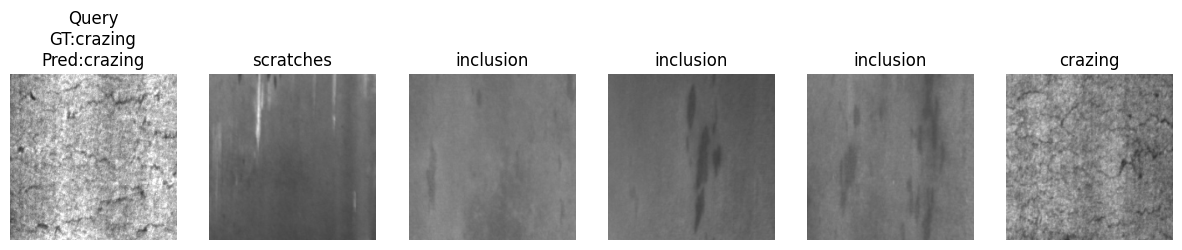

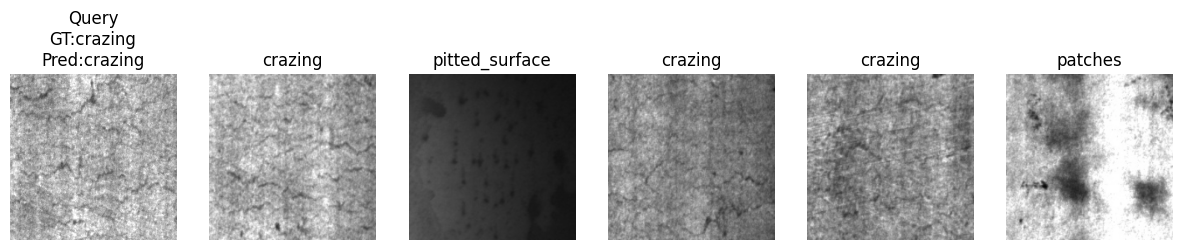

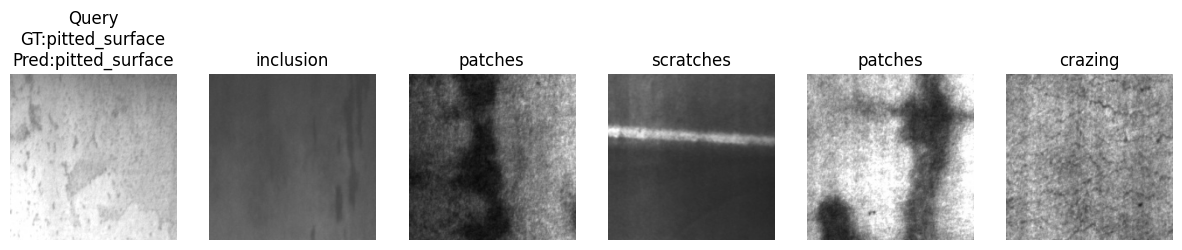

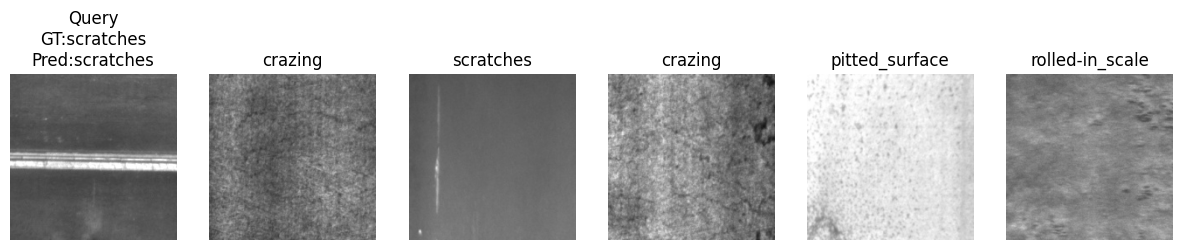

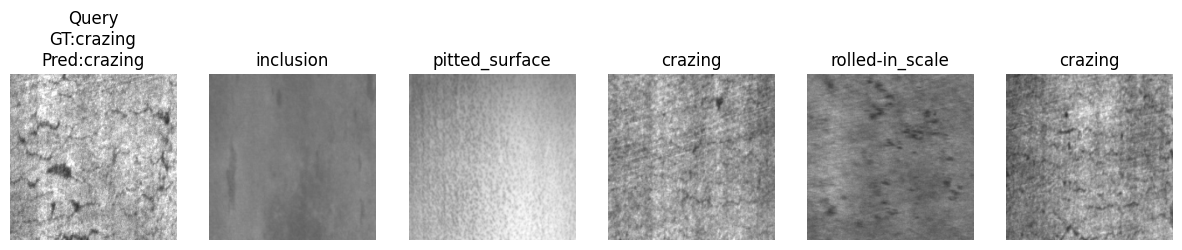

In [26]:
import random
from IPython.display import display

# Number of queries to show
num_queries = 5
top_k = 5

# Randomly sample images from validation set
sample_indices = random.sample(range(len(val_dataset)), num_queries)

for idx in sample_indices:
    img_path, true_label = val_dataset.imgs[idx]  # Image path and label
    img = Image.open(img_path).convert("RGB")

    # Transform + embedding
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(img_tensor).cpu().numpy()
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
        D, I = index.search(emb, top_k)
        pred_label = labels[I[0][0]]

    # Show query image
    plt.figure(figsize=(15,3))
    plt.subplot(1, top_k+1, 1)
    plt.imshow(img)
    plt.title(f"Query\nGT:{class_names[true_label]}\nPred:{class_names[pred_label]}")
    plt.axis("off")

    # Show top-k neighbors
    for i, nn_idx in enumerate(I[0]):
        neighbor_img_tensor, neighbor_label = train_dataset[nn_idx]
        # Convert tensor to image
        nn_img = neighbor_img_tensor.clone().cpu()
        nn_img = nn_img * torch.tensor([0.229,0.224,0.225]).view(3,1,1)
        nn_img = nn_img + torch.tensor([0.485,0.456,0.406]).view(3,1,1)
        nn_img = nn_img.clamp(0,1).permute(1,2,0).numpy()

        plt.subplot(1, top_k+1, i+2)
        plt.imshow(nn_img)
        plt.title(class_names[neighbor_label])
        plt.axis("off")

    plt.show()
